In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
import scipy.io
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.svm import LinearSVC  # a different way to implement linear SVC
from sklearn.multiclass import OneVsRestClassifier

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from nilearn import plotting
from nilearn.image import new_img_like

from scipy.stats import ttest_1samp, ttest_rel
from sklearn.ensemble import RandomForestClassifier

from sklearn.manifold import TSNE

from extract_beta import extract_beta_data, decode_pairwise

In [3]:
from nilearn.decoding import Decoder
from nilearn.image import load_img
from sklearn.model_selection import cross_val_score

In [4]:
root_dir = '/Users/qingfangliu/Library/CloudStorage/Dropbox/Project_SPEEDTMS/analysis'
local_dir = '/Users/qingfangliu/Experiment'

# Load subject information
sub_info_file = os.path.join(root_dir, 'data', 'SubInfo', 'SubjectConds.XLSX')
sub_info = pd.read_excel(sub_info_file)

# Extract subject indices and exclusion information
subs = sub_info['Sub']
excluded = sub_info['Excluded']
subs = subs[excluded == 0]  # Keep only subjects not excluded
nsubs = len(subs)

In [5]:
# to load data of beta estimates for decoding
nruns = 3
nSess = 2
nallruns = nruns * nSess
nconds = 3  # 3 different odor outcomes

In [6]:
# which decoding model to use?
# timing: odor delivery (outcome)
# single trials? or averaged across trials per run?

# try to recall, which GLM you used?
modelname = 'Revs_pseudoconcat_Nz'
conds = [{'1->2'}, {'1->3'}, {'2->1'}, {'2->3'}, {'3->1'}, {'3->2'}]
nconds = len(conds)

In [7]:
# Each entry: condition indices (1-based), label type, and a human-readable name
dpairs = [
    {'pair': [1, 2], 'type': 'diff_received', 'label': 'Expected=1'},
    {'pair': [3, 4], 'type': 'diff_received', 'label': 'Expected=2'},
    {'pair': [5, 6], 'type': 'diff_received', 'label': 'Expected=3'},
    
    {'pair': [1, 6], 'type': 'diff_expected', 'label': 'Received=2'},
    {'pair': [2, 4], 'type': 'diff_expected', 'label': 'Received=3'},
    {'pair': [3, 5], 'type': 'diff_expected', 'label': 'Received=1'},
]

ndpairs = len(dpairs)

In [8]:
maskpath = os.path.join(root_dir,'data','ROIs','rmean_fullMB_point1.nii') # which mask to use
# Load mask volume
mask_img = nib.load(maskpath)
mask_data = mask_img.get_fdata()
lin_index = np.where(mask_data > 0)  # linear index of non-zero voxels
nvox = len(mask_data[lin_index])

In [9]:
results = []

for sub in subs:
    try:
        subno, X, y, runs = extract_beta_data(
            sub=sub,
            local_dir=local_dir,
            modelname=modelname,
            nconds=6,
            nallruns=6,
            lin_index=lin_index
        )

        for pair_dict in dpairs:
            pair = pair_dict['pair']
            acc = decode_pairwise(X, y, runs, cond_pair=pair, scale='demean', clf_name = 'SVM', C=1)

            results.append({
                'subject': subno,
                'pair': pair,
                'type': pair_dict['type'],
                'label': pair_dict['label'],
                'accuracy': acc
            })

    except Exception as e:
        print(f"Error in subject {sub}: {e}")


Processing sub1...
Processing sub2...
Processing sub4...
Processing sub6...
Processing sub7...
Processing sub8...
Processing sub11...
Processing sub12...
Processing sub15...
Processing sub16...
Processing sub18...
Processing sub19...
Processing sub21...
Processing sub23...
Processing sub25...
Processing sub26...
Processing sub28...
Processing sub30...
Processing sub31...
Processing sub33...
Processing sub34...
Processing sub36...
Processing sub37...
Processing sub39...
Processing sub40...
Processing sub43...
Processing sub44...
Processing sub47...
Processing sub49...
Processing sub51...
Processing sub52...


In [10]:
df = pd.DataFrame(results)
#df.to_csv('mvpa_results.csv', index=False)


In [11]:
summary = df.groupby(['subject', 'type'])['accuracy'].mean().reset_index()
pivoted = summary.pivot(index='subject', columns='type', values='accuracy').dropna()

t_rec, p_rec = ttest_1samp(pivoted['diff_received'], 0.5)
t_exp, p_exp = ttest_1samp(pivoted['diff_expected'], 0.5)
t_stat, p_val = ttest_rel(pivoted['diff_received'], pivoted['diff_expected'])

print(f"diff_received: t={t_rec:.2f}, p={p_rec:.4f}")
print(f"diff_expected: t={t_exp:.2f}, p={p_exp:.4f}")
print(f"t = {t_stat:.2f}, p = {p_val:.4f}")

diff_received: t=3.13, p=0.0039
diff_expected: t=0.91, p=0.3709
t = 1.49, p = 0.1472


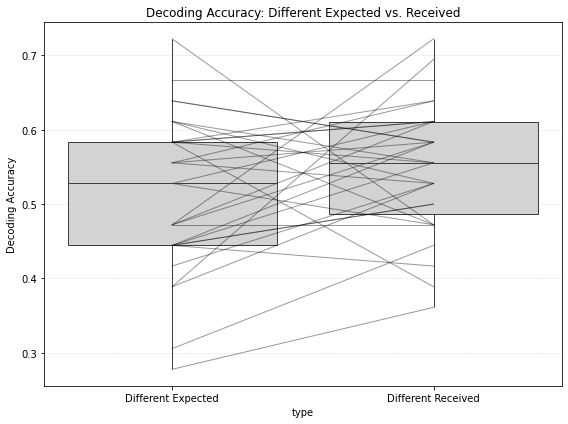

In [12]:
# Reshape for plotting
df_long = pivoted.reset_index().melt(id_vars='subject', 
                                     value_vars=['diff_expected', 'diff_received'],
                                     var_name='type', value_name='accuracy')

# Set consistent order and labels
type_order = ['diff_expected', 'diff_received']
type_labels = ['Different Expected', 'Different Received']

plt.figure(figsize=(8, 6))

# Plot boxplot
sns.boxplot(data=df_long, x='type', y='accuracy', order=type_order,
            showcaps=False, boxprops={'facecolor': 'lightgray'}, showfliers=False)

# Overlay line plot per subject
for sub in df_long['subject'].unique():
    subj_data = df_long[df_long['subject'] == sub]
    x_vals = [type_order.index(t) for t in subj_data['type']]
    plt.plot(x_vals, subj_data['accuracy'], color='black', alpha=0.4, linewidth=1)

# Customization
plt.xticks(ticks=[0, 1], labels=type_labels)
plt.ylabel('Decoding Accuracy')
plt.title('Decoding Accuracy: Different Expected vs. Received')
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
